# Implementação do Random Forest

In [2]:
TRAINING_DATASET_SOURCE = '../training_data.csv'  # Since we are one directory up, we should go down one directory to import the datasets
TEST_DATASET_SOURCE = '../test_data.csv'

In [3]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from pandas import DataFrame
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

# Definição dos dados de teste e de treino

In [4]:
print(train_df.shape, test_df.shape)

(5000, 13) (1206, 12)


In [5]:
train_df['incidents'].value_counts()

None         2028
High         1073
Low           718
Very_High     603
Medium        578
Name: incidents, dtype: int64

In [6]:
#count_class0, count_class1, count_class2, count_class3, count_class4 = train_df['incidents'].value_counts().to_frame()

incidents_count = train_df['incidents'].value_counts()

max_count = incidents_count.max()

print('Max value count:', max_count)

df_classes = []
for category, counts in zip(incidents_count.index, incidents_count):
    #print(category, counts)
    df_classes.append(train_df[train_df['incidents'] == category])

df_classes_over = []

for category in df_classes:
    df_classes_over.append(category.sample(max_count, replace=True))

df_test_over = pd.concat(df_classes_over, axis=0)

print(df_test_over['incidents'].value_counts())


Max value count: 2028
None         2028
High         2028
Low          2028
Very_High    2028
Medium       2028
Name: incidents, dtype: int64


In [7]:
features = df_test_over.drop(['incidents'], axis=1)
target = df_test_over['incidents']

all_features = features.columns.tolist()

In [8]:
features

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain
102,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-11-15 23:00,DARK,12.0,1020.0,70.0,1.0,0.0,Sem Chuva
2654,Guimaraes,UNDEFINED,0,",",2021-03-21 10:00,LIGHT,10.0,1025.0,45.0,1.0,0.0,Sem Chuva
3329,Guimaraes,UNDEFINED,0,",",2021-01-24 14:00,LIGHT,12.0,1015.0,83.0,1.0,0.0,Sem Chuva
2872,Guimaraes,UNDEFINED,0,",",2021-01-23 11:00,LIGHT,10.0,1010.0,91.0,1.0,0.0,chuva fraca
2017,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-07-03 00:00,DARK,17.0,1018.0,91.0,0.0,0.0,Sem Chuva
...,...,...,...,...,...,...,...,...,...,...,...,...
4882,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-23 21:00,DARK,18.0,1019.0,64.0,1.0,0.0,Sem Chuva
3373,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-25 00:00,DARK,19.0,1019.0,58.0,2.0,0.0,Sem Chuva
4278,Guimaraes,UNDEFINED,0,",",2021-01-29 23:00,DARK,12.0,1015.0,92.0,3.0,0.0,chuva fraca
2611,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-16 04:00,DARK,19.0,1011.0,82.0,1.0,0.0,Sem Chuva


### Obtenção das features numericas e categoricas

In [9]:
dropped_columns = ['city_name', 'avg_precipitation', 'magnitude_of_delay', 'record_date']

numerical_features = [column for column, dtype in zip(features.columns, features.dtypes)
                      if dtype.kind in ['i', 'f'] and column not in dropped_columns]

categorical_features = [column for column, dtype in zip(features.columns, features.dtypes)
                        if
                        dtype.kind not in ['i', 'f'] and column != 'affected_roads' and column not in dropped_columns]

### Divisão dos dados em dados de teste e treino

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=2000)

#### Criação de steps para tratar da remoção de features


In [11]:
# noinspection PyPep8Naming,PyMethodMayBeStatic
class ColumnsRemovalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: DataFrame, y=None):
        X_ = X.copy()

        X_.drop(columns=dropped_columns, inplace=True)

        return X_

#### Criação de steps para tratar da feature `record_date`

In [12]:
# noinspection PyPep8Naming,PyMethodMayBeStatic
class RecordDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: DataFrame, y=None):
        X_ = X.copy()

        ### Extrair a hora e dia da semana da feature 'record_date'
        record_date = pd.DatetimeIndex(X_['record_date'])

        X_['hour'] = record_date.hour
        X_['day'] = record_date.day
        X_['month'] = record_date.month
        X_['weekday'] = record_date.weekday

        X_.drop(columns=['record_date'], inplace=True)

        imputer = SimpleImputer(strategy='median')
        scaler = MinMaxScaler()

        imputer.fit(X_)
        X_ = imputer.transform(X_)

        scaler.fit(X_)
        X_ = scaler.transform(X_)

        return X_

#### Criação de steps para tratar da feature `affected_roads`

In [13]:
# noinspection PyPep8Naming,PyMethodMayBeStatic
class AffectedRoadsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: DataFrame, y=None):
        X_ = X.copy()

        road_quantity = []
        for line in X_['affected_roads']:
            unique_roads = set(str(line).split(','))
            valid_roads = [elem for elem in unique_roads if elem != '']
            count = len(valid_roads)
            road_quantity.append(count)

        X_['num_affected_roads'] = road_quantity
        X_.drop(columns=['affected_roads'], inplace=True)

        imputer = SimpleImputer(strategy='median')
        scaler = MinMaxScaler()

        imputer.fit(X_)
        X_ = imputer.transform(X_)

        scaler.fit(X_)
        X_ = scaler.transform(X_)

        return X_

### Pipeline de preparação de dados

In [14]:
preprocessor = make_column_transformer(
    (make_pipeline(
        AffectedRoadsTransformer()
    ), ['affected_roads']),

    (make_pipeline(
        RecordDateTransformer()
    ), ['record_date']),

    (make_pipeline(
        ColumnsRemovalTransformer()
    ), dropped_columns),

    (make_pipeline(
        SimpleImputer(strategy='median'),
        MinMaxScaler(),
    ), numerical_features),

    (make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(categories='auto', handle_unknown='ignore'),
    ), categorical_features),
)

In [15]:
X_train

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain
3993,Guimaraes,UNDEFINED,32,"N101,N101,N101,N101,N101,N101",2021-12-09 23:00,DARK,11.0,1025.0,94.0,0.0,0.0,Sem Chuva
3213,Guimaraes,UNDEFINED,0,",",2021-01-20 07:00,DARK,10.0,1003.0,90.0,2.0,0.0,chuva fraca
790,Guimaraes,UNDEFINED,877,"N101,N101,N101,N101,N105,N101,N101,N101,N101,N...",2021-06-30 19:00,LIGHT,20.0,1016.0,56.0,1.0,0.0,Sem Chuva
1483,Guimaraes,UNDEFINED,404,"N101,N101,N101,N206,N101,N101",2021-07-09 10:00,LIGHT,21.0,1020.0,35.0,0.0,0.0,Sem Chuva
3327,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-04-17 20:00,LOW_LIGHT,16.0,1018.0,59.0,3.0,0.0,Sem Chuva
...,...,...,...,...,...,...,...,...,...,...,...,...
4994,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-23 22:00,DARK,17.0,1020.0,67.0,2.0,0.0,Sem Chuva
256,Guimaraes,UNDEFINED,90,",",2021-02-02 22:00,DARK,12.0,1010.0,92.0,0.0,0.0,chuva fraca
1811,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-11-01 08:00,LIGHT,11.0,1016.0,94.0,0.0,0.0,Sem Chuva
493,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-07 00:00,DARK,16.0,1021.0,79.0,1.0,0.0,chuva fraca


In [16]:
preprocessor.fit(X_train)
preprocessor.transform(X_train)

array([[0.125     , 1.        , 0.26666667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.30434783, 0.63333333, ..., 0.        , 1.        ,
        0.        ],
       [0.25      , 0.82608696, 0.96666667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.125     , 0.34782609, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.125     , 0.        , 0.2       , ..., 0.        , 1.        ,
        0.        ],
       [0.25      , 0.52173913, 0.46666667, ..., 0.        , 0.        ,
        0.        ]])

In [17]:
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif

preprocessor_best = make_pipeline(preprocessor, VarianceThreshold())#, SelectKBest(f_classif, k='all'))

In [18]:
from sklearn.ensemble import RandomForestClassifier

RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators=100))

In [19]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

1.0

In [20]:
RF_Model.score(X_test, y_test)

0.9819197896120972

## Hyperparameter Tuning

In [21]:
import numpy as np

n_estimators = [int(x) for x in np.linspace(start=10, stop=500, num=5)]

max_features = ['sqrt']

max_depth = [2, 6, 12, 20, 30, 40, 50]

min_samples_split = [2, 5, 30]

min_samples_leaf = [1, 2, 50]

bootstrap = [True, False]

criterions = ["gini", "entropy", "log_loss"]

In [22]:
param_grid = {
    'randomforestclassifier__n_estimators': n_estimators,
    'randomforestclassifier__max_features': max_features,
    'randomforestclassifier__max_depth': max_depth,
    'randomforestclassifier__min_samples_split': min_samples_split,
    'randomforestclassifier__min_samples_leaf': min_samples_leaf,
    'randomforestclassifier__bootstrap': bootstrap,
    'randomforestclassifier__criterion': criterions
}

param_grid

{'randomforestclassifier__n_estimators': [10, 132, 255, 377, 500],
 'randomforestclassifier__max_features': ['sqrt'],
 'randomforestclassifier__max_depth': [2, 6, 12, 20, 30, 40, 50],
 'randomforestclassifier__min_samples_split': [2, 5, 30],
 'randomforestclassifier__min_samples_leaf': [1, 2, 50],
 'randomforestclassifier__bootstrap': [True, False],
 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}

In [23]:
from sklearn import metrics

print(metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 

In [24]:
from sklearn.model_selection import GridSearchCV

rf_RandomGrid = RandomizedSearchCV(estimator=RF_Model, param_distributions=param_grid, cv=20, verbose=1, n_jobs=-1,
                                   n_iter=50, scoring='balanced_accuracy', random_state=1000)


#rf_RandomGrid = GridSearchCV(estimator=RF_Model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='balanced_accuracy')

In [25]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 20 folds for each of 50 candidates, totalling 1000 fits
CPU times: total: 5.77 s
Wall time: 1min 45s


RandomizedSearchCV(cv=20,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('affectedroadstransformer',
                                                                                                                 AffectedRoadsTransformer())]),
                                                                                                ['affected_roads']),
                                                                                               ('pipeline-2',
                                                                                                Pipeline(steps=[('recorddatetransformer',
                                                                                                                 RecordDateTransformer())]),
                                                                                                ['record_date']),
                                                                                               ('pipeline-...
                                        'randomforestclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_depth': [2,
                                                                              6,
                                                                              12,
                                                                              20,
                                                                              30,
                                                                              40,
                                                                              50],
                                        'randomforestclassifier__max_features': ['sqrt'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     50],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      30],
                                        'randomforestclassifier__n_estimators': [10,
                                                                                 132,
                                                                                 255,
                                                                                 377,
                                                                                 500]},
                   random_state=1000, scoring='balanced_accuracy', verbose=1)

In [26]:
rf_RandomGrid.score(X_train, y_train)

1.0

In [27]:
rf_RandomGrid.cv_results_

{'mean_fit_time': array([1.35969816, 1.67659901, 1.34374932, 0.99050012, 0.68334918,
        0.13559951, 2.24194837, 2.98019947, 2.5046995 , 0.75274981,
        0.84539882, 4.63024957, 1.16200007, 0.97285006, 2.9794497 ,
        0.10054936, 3.09569937, 0.71529962, 0.67464972, 0.60764942,
        0.98964955, 1.65734891, 0.10834894, 1.23209949, 2.04039958,
        0.10864953, 2.43305014, 0.11725001, 1.15399951, 2.39454944,
        0.57219987, 0.77419863, 3.04420015, 1.30004966, 2.19934981,
        0.80210024, 1.42920027, 0.08354968, 2.78494858, 1.99949923,
        3.03214976, 0.12949922, 1.01904873, 0.69364941, 0.42119966,
        0.674649  , 0.67854997, 2.17269921, 1.12885023, 1.10459942]),
 'std_fit_time': array([0.2163906 , 0.23204142, 0.19565844, 0.20941102, 0.11072537,
        0.02359831, 0.36515194, 0.48857099, 0.24730215, 0.12207947,
        0.13712213, 0.56591655, 0.16366145, 0.1545618 , 0.27994366,
        0.02205703, 0.33178251, 0.11883005, 0.13081499, 0.11281387,
        0.163

In [28]:
rf_RandomGrid.best_score_

0.977881791303169

In [29]:
rf_RandomGrid.best_params_

{'randomforestclassifier__n_estimators': 132,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 50,
 'randomforestclassifier__criterion': 'log_loss',
 'randomforestclassifier__bootstrap': False}

In [30]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('affectedroadstransformer',
                                                                                    AffectedRoadsTransformer())]),
                                                                   ['affected_roads']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('recorddatetransformer',
                                                                                    RecordDateTransformer())]),
                                                                   ['record_date']),
                                                                  ('pipeline-3',
                                                                   Pipeline(steps=[('columnsremoval...
                                                                  ('pipeline-5',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['luminosity',
                                                                    'avg_rain'])])),
                                 ('variancethreshold', VarianceThreshold())])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='log_loss',
                                        max_depth=50, n_estimators=132))])

In [31]:
print(f'Train: {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test: {rf_RandomGrid.score(X_test, y_test):.3f}')

Train: 1.000
Test: 0.981


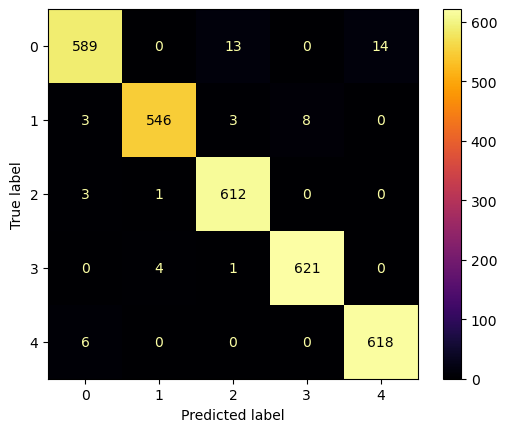

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_RandomGrid.predict(X_test)

cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot(cmap='inferno')

### Obtenção das previsões do dataset de submissão

In [33]:
features = test_df.copy()

preprocessor.fit(features)
preprocessor.transform(features)

predictions = rf_RandomGrid.predict(features)
predictions_df = pd.DataFrame(predictions)
predictions_df.index += 1
predictions_df.to_csv("../submission.csv", header=['Incidents'], index_label='RowId')